In [1]:
import os
import cv2
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

In [2]:
# defining training & testing data path
train_data_path=r'C:\Users\Ravi\Downloads\dementia\archive (1)\Combined Dataset\train'
test_data_path=r'C:\Users\Ravi\Downloads\dementia\archive (1)\Combined Dataset\test'

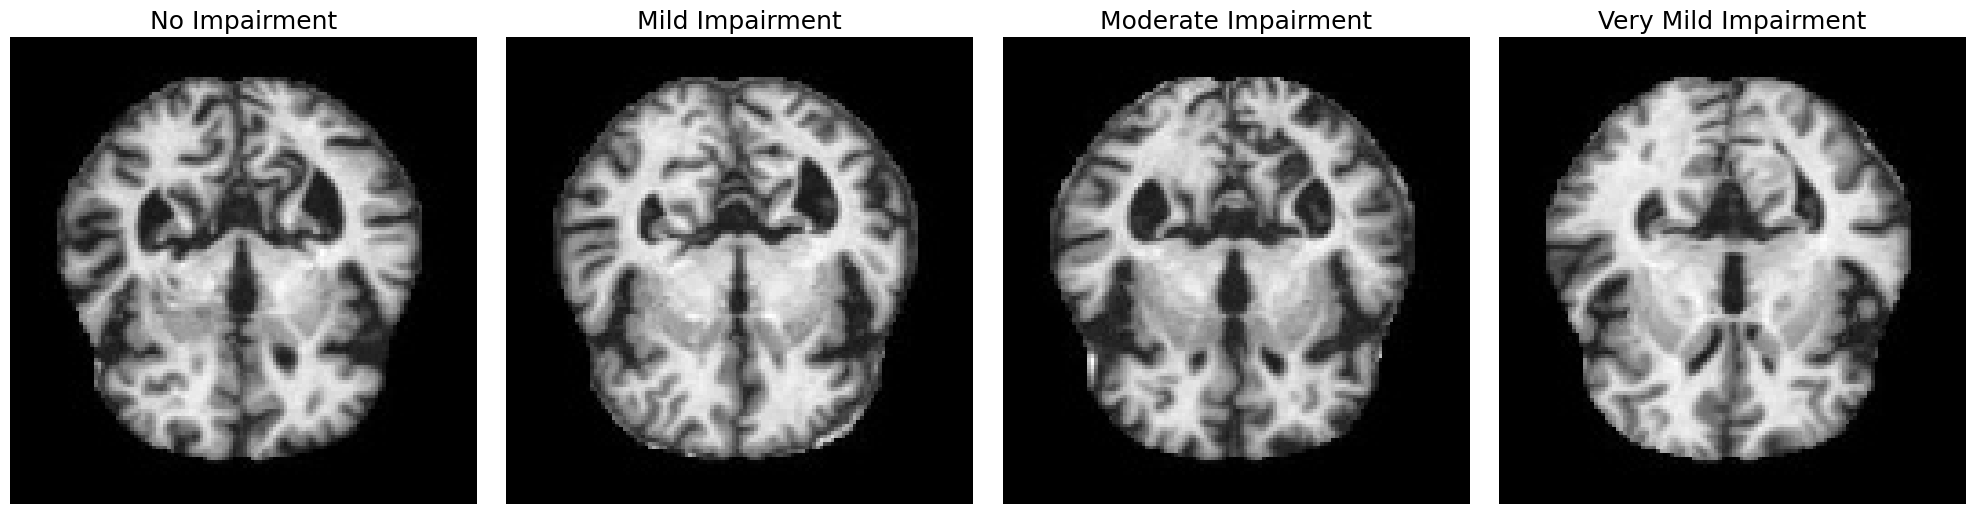

In [3]:
# Load the images
no_impairment = imread(train_data_path+"/No Impairment"+"/NoImpairment (1).jpg")
mild_impairment = imread(train_data_path+"/Mild Impairment"+"/MildImpairment (1).jpg")
moderate_impairment = imread(train_data_path+"/Moderate Impairment"+"/ModerateImpairment (1).jpg")
very_mild_impairment = imread(train_data_path+"/Very Mild Impairment"+"/VeryMildImpairment (1).jpg")


# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes = axes.flatten()

axes[0].imshow(no_impairment, cmap='gray')
axes[0].set_title('No Impairment', fontsize=18)
axes[0].axis('off')

axes[1].imshow(mild_impairment, cmap='gray')
axes[1].set_title('Mild Impairment', fontsize=18)
axes[1].axis('off')

axes[2].imshow(moderate_impairment, cmap='gray')
axes[2].set_title('Moderate Impairment', fontsize=18)
axes[2].axis('off')

axes[3].imshow(very_mild_impairment, cmap='gray')
axes[3].set_title('Very Mild Impairment', fontsize=18)
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Data shape
random_image=train_data_path+"/No Impairment"+"/NoImpairment (1).jpg"
print("Image Shape:",cv2.imread(random_image).shape)

Image Shape: (128, 128, 3)


In [5]:
# Data shape
random_image=train_data_path+"/No Impairment"+"/NoImpairment (1).jpg"
print("Image Shape:",cv2.imread(random_image).shape)

Image Shape: (128, 128, 3)


In [6]:
def data_preprocessing(output_size, val_split=0.1):
    # ImageDataGenerator for training with validation split
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       zoom_range=0.2,
                                       shear_range=0.2,
                                       rotation_range=15,
                                       fill_mode='nearest',
                                       horizontal_flip=True,
                                       validation_split=val_split)  

    # Training data generator
    training_set = train_datagen.flow_from_directory(train_data_path,
                                                     target_size=(output_size, output_size),
                                                     batch_size=32,
                                                     class_mode='categorical',
                                                     shuffle=True,
                                                     subset='training')  

    # Validation data generator
    validation_set = train_datagen.flow_from_directory(train_data_path,
                                                       target_size=(output_size, output_size),
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       subset='validation')  

    return training_set, validation_set


# Splitting Data
training_set, validation_set = data_preprocessing(output_size=150, val_split=0.1)

Found 9216 images belonging to 4 classes.
Found 1024 images belonging to 4 classes.


In [7]:
# Training & Validation data Size
print("Training set distribution:", dict(pd.Series(training_set.classes).value_counts()))
print("\nValidation set distribution:", dict(pd.Series(validation_set.classes).value_counts()))

Training set distribution: {0: 2304, 1: 2304, 2: 2304, 3: 2304}

Validation set distribution: {0: 256, 1: 256, 2: 256, 3: 256}


In [8]:
# Load the pre-trained VGG16 model (excluding the top layers) with weights from ImageNet
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of VGG16 so that they are not trainable
vgg_base.trainable = False

# Initialize the Sequential model
model = Sequential([
    # VGG16 as the base feature extractor
    vgg_base,

    # Flatten the output of the VGG16 base
    Flatten(),

    # Fully Connected Layer 1
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Fully Connected Layer 2
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    

    # Output Layer with Softmax Activation (for 4 classes)
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,847,044 (64.27 MB)

 Trainable params: 2,131,588 (8.13 MB)

 Non-trainable params: 14,715,456 (56.14 MB)

In [9]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Training the model
history = model.fit(training_set, validation_data = validation_set, batch_size = 64, epochs= 50, verbose = 1)
model.save('model.h5')

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.7807 - loss: 0.5188 - val_accuracy: 0.7148 - val_loss: 0.5753
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 279s 965ms/step - accuracy: 0.7762 - loss: 0.5217 - val_accuracy: 0.7178 - val_loss: 0.5834
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 246s 852ms/step - accuracy: 0.7762 - loss: 0.5244 - val_accuracy: 0.6943 - val_loss: 0.7125
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 246s 852ms/step - accuracy: 0.7939 - loss: 0.4927 - val_accuracy: 0.7393 - val_loss: 0.6032
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 247s 856ms/step - accuracy: 0.7980 - loss: 0.4798 - val_accuracy: 0.7344 - val_loss: 0.5420
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 245s 848ms/step - accuracy: 0.7893 - loss: 0.4957 - val_accuracy: 0.7354 - val_loss: 0.5217
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 246s 853ms/step - accuracy: 0.7946 - loss: 0.4795 - val_accuracy: 0.7441 - val_loss: 0.5673
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 249s 861ms/step - accuracy: 0.8025 - lo

In [14]:
model.save('model.keras')

In [1]:
# Evaluate model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(test_data_path,
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)  

test_loss, test_accuracy = model.evaluate(test_set, verbose=1)

# Print the test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

NameError: name 'ImageDataGenerator' is not defined